In [1]:
! nvidia-smi

Mon Sep 28 02:31:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Install torch stable version 1.5

In [3]:
!pip install torch==1.5.1+cu92 torchvision==0.6.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch;print(torch.__version__)

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 604.8MB 24kB/s 
     |████████████████████████████████| 6.5MB 645kB/s 
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101
1.5.1+cu92


# Dataset preparation

In [2]:
!wget https://github.com/sumankanukollu/suman_cnn/raw/master/sessions/s6_GAN_Car_real_fake/dataset/processed.zip

--2020-09-28 02:31:18--  https://github.com/sumankanukollu/suman_cnn/raw/master/sessions/s6_GAN_Car_real_fake/dataset/processed.zip
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/sumankanukollu/suman_cnn/master/sessions/s6_GAN_Car_real_fake/dataset/processed.zip [following]
--2020-09-28 02:31:19--  https://raw.githubusercontent.com/sumankanukollu/suman_cnn/master/sessions/s6_GAN_Car_real_fake/dataset/processed.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2103687 (2.0M) [application/zip]
Saving to: ‘processed.zip’

processed.zip       100%[===================>]   2.01M  --.-KB/s    in 0.1s

In [4]:
import os
homepath = '/content/'
datasetZip = '/content/processed.zip'
ds = '/content/processed'

In [5]:
from zipfile import ZipFile
if not os.path.isdir(os.path.join(homepath,'processed')):
    with ZipFile(datasetZip) as z:
        z.extractall()

In [6]:
from pathlib import Path
from PIL import Image
from random import shuffle

car_images = Path(ds).glob('*/*')
car_images = list(car_images)
len(car_images)


1055

# Import packages

In [7]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


# Variables declarations

In [8]:
dataroot = ds

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 64

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 2000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Data loading

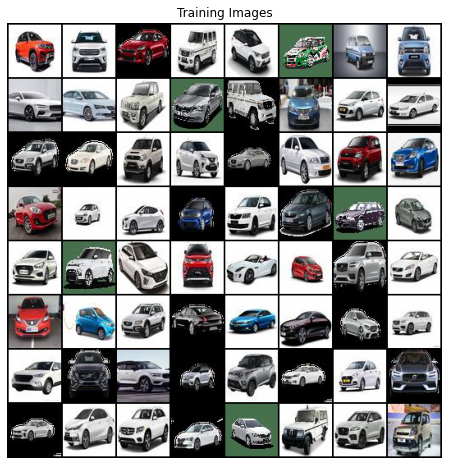

In [9]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                            ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

# Mean and Std calculation

In [10]:
mean,std,nb_samples  = 0.,0.,0.
for dl in iter(dataloader):
    #i1,i2 = next(dl)
    i1,i2 = dl
    batch_samples = i1.shape[0]
    data = i1.view(i1.shape[0],i1.shape[1],-1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
    
print(mean,std,nb_samples)
    
mean /= nb_samples
std /= nb_samples


print(mean,std)

tensor([559.8555, 551.0414, 553.3123]) tensor([314.6864, 313.7487, 313.4396]) 1055.0
tensor([0.5307, 0.5223, 0.5245]) tensor([0.2983, 0.2974, 0.2971])


In [11]:
print(mean,std,nb_samples)

tensor([0.5307, 0.5223, 0.5245]) tensor([0.2983, 0.2974, 0.2971]) 1055.0


In [12]:
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5307, 0.5223, 0.5245), (0.2983, 0.2974, 0.2971)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# custom weights initialization called on netG and netD

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator Code

In [14]:
class Generator(nn.Module):
    """
    Creates the Generator

    nz (int): size of the latent z vector
    ngf (int): number of feature maps for the generator
    """
    def __init__(self, nz: int = 64, ngf: int = 64):
        super(Generator, self).__init__()
        #self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

# Descriminator code

In [15]:
class Discriminator(nn.Module):
    """
    Creates the Discriminator

    nc (int): number of channels of the input image
    ndf (int): number of feature maps for the discriminator

    This uses the special Spectral Normalization ref: https://arxiv.org/abs/1802.05957
    """
    def __init__(self, nc: int = 3, ndf: int = 64):
        super(Discriminator, self).__init__()
        #self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# initiate Generator and Descriminator

In [16]:
# Create the generator
netG = Generator(nz, ngf).to(device)

# Handle multi-gpu if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [17]:
# Create the Discriminator
netD = Discriminator(nc, ndf).to(device)

# Handle multi-gpu if desired
#if (device.type == 'cuda') and (ngpu > 1):
#    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# Model Summary:

In [18]:
from torchsummary import summary 
summary(netG, input_size=(64, 1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         524,288
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [19]:
summary(netD, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           3,072
         LeakyReLU-2           [-1, 64, 64, 64]               0
            Conv2d-3          [-1, 128, 32, 32]         131,072
       BatchNorm2d-4          [-1, 128, 32, 32]             256
         LeakyReLU-5          [-1, 128, 32, 32]               0
            Conv2d-6          [-1, 256, 16, 16]         524,288
       BatchNorm2d-7          [-1, 256, 16, 16]             512
         LeakyReLU-8          [-1, 256, 16, 16]               0
            Conv2d-9            [-1, 512, 8, 8]       2,097,152
      BatchNorm2d-10            [-1, 512, 8, 8]           1,024
        LeakyReLU-11            [-1, 512, 8, 8]               0
           Conv2d-12              [-1, 1, 5, 5]           8,192
          Sigmoid-13              [-1, 1, 5, 5]               0
Total params: 2,765,568
Trainable param

In [20]:
netD(torch.randn(batch_size, 3, 64, 64).to(device)).shape

torch.Size([256, 1, 1, 1])

In [21]:
netG(torch.randn(batch_size, 64, 1, 1).to(device)).shape

torch.Size([256, 3, 64, 64])

# Trainning

In [22]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [23]:
# Training Loop
import time
# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []

print(f"=> Starting Training Loop for {num_epochs} epochs\n")

print_freq = 20

curr_time = time.time()
# For each epoch
for epoch in range(num_epochs):

    # For each batch in the dataloader
    for i, data in enumerate(dataloader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
    epoch_end = time.time()

    # Output training stats every `print_freq` or if its end epoch
    if epoch % print_freq == 0 or epoch == num_epochs -1:
        with torch.no_grad():
            fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        generator_log = Path('generator_log')
        generator_log.mkdir(parents=True, exist_ok=True) 

        plt.imsave(generator_log / f'g_log_{epoch:04}.jpg', np.transpose(img_list[-1].numpy(), (1, 2, 0)))

        checkpoint_dir = Path('checkpoints')
        checkpoint_dir.mkdir(parents=True, exist_ok=True)

        torch.save(netG.state_dict(), checkpoint_dir / f'netG_chkpt_{epoch:04}.pth')

        print('=> Epoch [%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f\tTime: %.5fs'
                  % (epoch, num_epochs-1, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2, time.time()-curr_time))
        # start the timer again
        curr_time = time.time()

=> Starting Training Loop for 2000 epochs

=> Epoch [0/1999]	Loss_D: 0.4519	Loss_G: 8.0074	D(x): 0.8805	D(G(z)): 0.1812 / 0.0004	Time: 1.07960s
=> Epoch [20/1999]	Loss_D: 0.3990	Loss_G: 4.5647	D(x): 0.8697	D(G(z)): 0.1777 / 0.0248	Time: 19.58752s
=> Epoch [40/1999]	Loss_D: 0.0950	Loss_G: 4.6773	D(x): 0.9649	D(G(z)): 0.0555 / 0.0144	Time: 19.62780s
=> Epoch [60/1999]	Loss_D: 0.6274	Loss_G: 3.1130	D(x): 0.6522	D(G(z)): 0.0355 / 0.1026	Time: 19.57562s
=> Epoch [80/1999]	Loss_D: 0.2970	Loss_G: 3.9448	D(x): 0.8850	D(G(z)): 0.1321 / 0.0251	Time: 19.57047s
=> Epoch [100/1999]	Loss_D: 0.2578	Loss_G: 3.8025	D(x): 0.9014	D(G(z)): 0.1306 / 0.0299	Time: 19.72413s
=> Epoch [120/1999]	Loss_D: 5.7565	Loss_G: 7.9735	D(x): 0.9984	D(G(z)): 0.9505 / 0.0016	Time: 19.78646s
=> Epoch [140/1999]	Loss_D: 0.2543	Loss_G: 3.7416	D(x): 0.8791	D(G(z)): 0.1017 / 0.0329	Time: 19.93935s
=> Epoch [160/1999]	Loss_D: 0.3489	Loss_G: 3.4433	D(x): 0.8124	D(G(z)): 0.1046 / 0.0538	Time: 19.57953s
=> Epoch [180/1999]	Loss_D: 

In [24]:
! ls -hl checkpoints

! zip -rq car_gan_g_log.zip generator_log/
! zip -rq car_gan_custom_checkpoints.zip checkpoints/

total 1.3G
-rw-r--r-- 1 root root 13M Sep 28 02:36 netG_chkpt_0000.pth
-rw-r--r-- 1 root root 13M Sep 28 02:36 netG_chkpt_0020.pth
-rw-r--r-- 1 root root 13M Sep 28 02:37 netG_chkpt_0040.pth
-rw-r--r-- 1 root root 13M Sep 28 02:37 netG_chkpt_0060.pth
-rw-r--r-- 1 root root 13M Sep 28 02:37 netG_chkpt_0080.pth
-rw-r--r-- 1 root root 13M Sep 28 02:38 netG_chkpt_0100.pth
-rw-r--r-- 1 root root 13M Sep 28 02:38 netG_chkpt_0120.pth
-rw-r--r-- 1 root root 13M Sep 28 02:38 netG_chkpt_0140.pth
-rw-r--r-- 1 root root 13M Sep 28 02:39 netG_chkpt_0160.pth
-rw-r--r-- 1 root root 13M Sep 28 02:39 netG_chkpt_0180.pth
-rw-r--r-- 1 root root 13M Sep 28 02:39 netG_chkpt_0200.pth
-rw-r--r-- 1 root root 13M Sep 28 02:40 netG_chkpt_0220.pth
-rw-r--r-- 1 root root 13M Sep 28 02:40 netG_chkpt_0240.pth
-rw-r--r-- 1 root root 13M Sep 28 02:40 netG_chkpt_0260.pth
-rw-r--r-- 1 root root 13M Sep 28 02:41 netG_chkpt_0280.pth
-rw-r--r-- 1 root root 13M Sep 28 02:41 netG_chkpt_0300.pth
-rw-r--r-- 1 root root 13M Se

# Save the model and optimizers

[(1840, 9.999999999999983e-05), (1700, 0.0002000000000000001), (1040, 0.0002999999999999999), (1120, 0.0002999999999999999), (1960, 0.00039999999999999975), (1380, 0.00039999999999999996), (1820, 0.00039999999999999996), (1060, 0.0004000000000000002), (1940, 0.0004000000000000002), (560, 0.00040000000000000105), (760, 0.0004999999999999996), (1340, 0.0005000000000000004), (1400, 0.0005000000000000004), (460, 0.0005999999999999964), (1360, 0.0008000000000000004), (820, 0.0008999999999999998), (1600, 0.0009000000000000002), (740, 0.0011999999999999997), (1800, 0.0014000000000000002), (1140, 0.0014999999999999996), (1320, 0.0014999999999999996), (1720, 0.0014999999999999996), (1760, 0.0014999999999999998), (1080, 0.0015000000000000005), (720, 0.0017999999999999995), (1100, 0.0018000000000000004), (1260, 0.002), (1680, 0.002), (360, 0.0022000000000000006), (700, 0.0022000000000000006), (1980, 0.0027999999999999995), (920, 0.0028000000000000004), (1540, 0.0028000000000000004), (980, 0.0034000000000000002), (1520, 0.003599999999999999), (1560, 0.0039000000000000003), (940, 0.0040999999999999995), (1500, 0.004300000000000002), (840, 0.0046), (1280, 0.004900000000000001), (680, 0.005499999999999998), (1240, 0.0058000000000000005), (1300, 0.0058000000000000005), (900, 0.006299999999999999), (1020, 0.006500000000000001), (1440, 0.0069), (1780, 0.0074), (1640, 0.007600000000000001), (1999, 0.007600000000000001), (1480, 0.007699999999999999), (1200, 0.0081), (800, 0.008600000000000002), (1220, 0.008900000000000002), (1620, 0.009000000000000001), (860, 0.0091), (620, 0.0098), (1660, 0.0115), (1460, 0.0127), (1580, 0.0132), (880, 0.013600000000000001), (380, 0.014700000000000001), (520, 0.016400000000000005), (960, 0.018500000000000003), (1000, 0.0192), (600, 0.0208), (480, 0.020800000000000003), (340, 0.0221), (240, 0.029699999999999997), (440, 0.031099999999999996), (1880, 0.0335), (1160, 0.0376), (640, 0.0389), (40, 0.0411), (780, 0.0441), (540, 0.045), (1920, 0.0475), (160, 0.0508), (1900, 0.051500000000000004), (1740, 0.0519), (1180, 0.0579), (420, 0.0659), (60, 0.06709999999999999), (140, 0.0688), (500, 0.0796), (300, 0.0839), (320, 0.09140000000000001), (660, 0.0983), (100, 0.1007), (400, 0.1024), (80, 0.107), (1860, 0.1108), (200, 0.1247), (280, 0.13999999999999999), (20, 0.1529), (0, 0.1808), (220, 0.2143), (180, 0.21760000000000002), (1420, 0.2856), (580, 0.3675), (260, 0.4825), (120, 0.9489)]


In [25]:
state = {
    'epoch': epoch,
    'netD': netD.state_dict(),
    'netG': netG.state_dict(),
    'optimizerD': optimizerD.state_dict(),
    'optimizerG': optimizerG.state_dict(),
    'img_list': img_list
}
torch.save(state, '/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/s6_carGAN_custom_checkpoints.pth')

In [31]:
!cp -r '/content/checkpoints' '/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/'

In [36]:
import sys;sys.getsizeof('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/')

124

In [39]:
!cp '/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/checkpoints/netG_chkpt_1840.pth' '/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1840.pth'

# Train graph

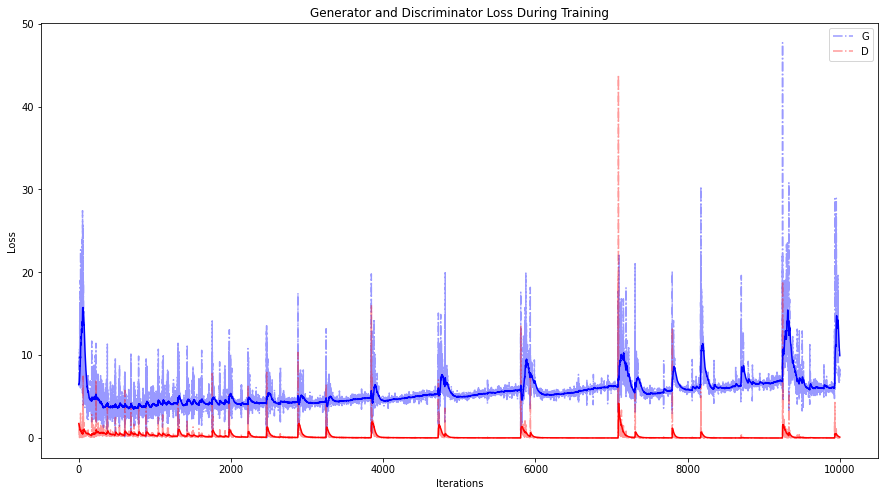

In [40]:
def smooth_curv(scalars, weight):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value

    return np.array(smoothed)

plt.figure(figsize=(15, 8))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, 'b-.',label="G", alpha=0.4)
plt.plot(D_losses, 'r-.', label="D", alpha=0.4)
plt.plot(smooth_curv(G_losses, 0.95), 'b')
plt.plot(smooth_curv(D_losses, 0.95), 'r')
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
!apt install imagemagick

In [28]:
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(45,45))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [29]:
import matplotlib
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
matplotlib.rcParams['animation.embed_limit'] = 2**128
HTML(ani.to_jshtml())

In [30]:
#anim.save('../../files/animation.gif', writer='imagemagick', fps=60)
ani.save('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6GanOnCars_2k_epochs_torch1.5.gif', writer='imagemagick', fps=10000)

# Load model 

In [41]:
def norm_ip(img, min, max):
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max - min + 1e-5)

def norm_tensor(t):
    norm_ip(t, float(t.min()), float(t.max()))

In [42]:
netG.load_state_dict(torch.load('/content/drive/My Drive/EVA4/phase2/s6_GAN_carDesign/s6_carGAN_checkpoints/netG_chkpt_1840.pth'))

<All keys matched successfully>

In [45]:
with torch.no_grad():
    fake = netG(torch.randn(1, 64, 1, 1).to(device)).detach().cpu()
fakei = fake[0]
norm_tensor(fakei)

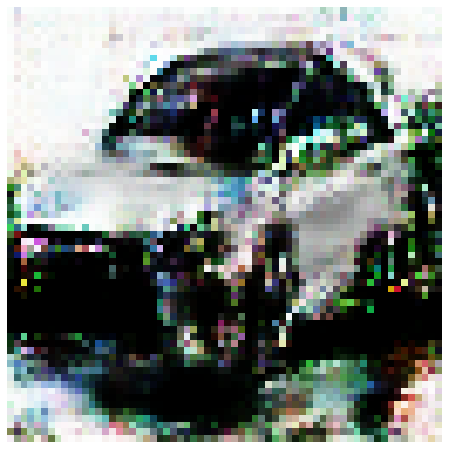

In [46]:
plt.figure(figsize=(8, 8))
plt.imshow(fakei.permute(1, 2, 0))
plt.axis('off')
plt.grid('off')